# Hagen-Poiseuille flow


## Description

Simulate transition from uniform plug inlet to fully developed parabolic profile in laminar pipe flow.

### Entrance length (99% developed)

L_e / D ≈ 0.06 × Re_D (theoretical approximation for Re < 2300)
### Recommended domain length
L ≥ 1.5–2.5 × L_e (ideally L/D ≈ 12–20)

### Typical test case (recommended starting point)

- Radius r = 0.5 → D = 1.0
- Re_D = 100 → L_e ≈ 6.0
- Tube length L = 15.0 (L/D = 15)
- Inlet: uniform plug velocity U_avg = U_inlet = 0.1 (along z)
- Developed centerline velocity U_max = 2 × U_avg = 0.2
- Fluid: ρ = 1.0, μ = (ρ U_avg D) / Re_D = 0.001
- Pressure gradient G = 8 μ U_avg / r² ≈ 0.0032 (for reference)

## Mesh recommendations

- Radial resolution: ≥ 10–12 points from center to wall
- Axial spacing: Δz ≈ 0.05–0.15
- cube_to_tube(r=0.5, refinements=2–3, height=L)
- Use cdist=1e-10 for merging

## Boundary conditions summary

- Walls: no-slip (u = 0 on side_boundary)
- Inlet: new vertex layers with fixed plug velocity U_z = U_avg
- Outlet: free outflow (remove exiting vertices, fixed P=0 or do-nothing)

## Validation targets

- Radial velocity profiles u_z(r) at z = 0, L_e/2, L_e, 1.5 L_e, 2 L_e
- Centerline velocity growth vs z
- Mass conservation (total ∑ m_v should stay nearly constant)


### Analytical equilibrium initial conditions and tests

Key assumptions (tunable via parameters):

- Tube/channel along z-axis (3D) or x-axis (2D planar).
- No-slip walls (velocity = 0 at boundary).
- 3D: axisymmetric Hagen-Poiseuille, radial coordinate r = sqrt(x² + y²), max centerline velocity U_max.
- 2D: parabolic u_x(y) between plates at y = y_lb and y = y_ub.
- Pressure stored as vector v.P (diagonal gradient potential, per your code).
- Velocity stored as v.u (vector).
- Use your dudt, dP, du operators (they already support dim=3 via e_star/v_star).

Summary of parameters, ICs and BCs:

In [1]:
# General imports
import numpy as np
from scipy.spatial import Delaunay  # if needed for mesh checks
import matplotlib.pyplot as plt


In [2]:
# Library specific imports
#from ddgclib.dynamic_integrators._integrators_dynamic import dudt

# compute duals (and Delaunay dual from a set of points)
from ddgclib.barycentric._duals import compute_vd#, triang_dual

# Import plotting functions
from ddgclib._plotting import plot_polyscope, plot_dual

# import
from ddgclib.barycentric._duals import dudt


## Case specific setup and imports

In [22]:
from src._plot_helpers import (
    extract_radial_profiles,
    plot_radial_profiles,
    plot_centerline_velocity
)

# Plot helpers
from src._plot_helpers import (
    extract_radial_profiles,
    plot_radial_profiles,
    plot_centerline_velocity,
    plot_3d_velocity
)

# Import parameters from _params.py
from src._params import r, D, L, Re_D, U_avg, U_max, rho, mu, L_e_approx, G, refinements, cdist, inlet_layer_thickness, outlet_buffer, add_inlet_every, CFL_target, print_params
print_params()

# Geometry
from src._geometry import cube_to_tube

# Import analytical solutions and IC/ test functions
from src._analytical_equil import (
    poiseuille_analytical_2d,
    poiseuille_analytical_3d,
    P_gradient_analytical,
    set_equilibrium_IC_2d,
    set_equilibrium_IC_3d,
    test_analytical_equilibrium_2d,
    test_analytical_equilibrium_3d
)

=== Hagen–Poiseuille Developing Flow Configuration ===
Radius r          = 0.5 m
Diameter D        = 1.0 m
Tube length L     = 15.0 m  (L/D = 15.0)
Re_D              = 100
Entrance length   ≈ 6.00 m  (L_e/D ≈ 6.0)
Inlet U_avg       = 0.1 m/s
Developed U_max   = 0.2 m/s
Density ρ         = 1.0 kg/m³
Viscosity μ       = 0.00100 Pa·s
Pressure gradient G = 0.00320 Pa/m


Usage notes:

- Call set_equilibrium_IC_2d(HC, ...) or _3d after mesh creation (cube_to_tube or your incomp_poiseuille_2d).
- Adjust G (pressure gradient) or U_max/R to match your physical scaling.
- Run the test_* functions immediately after setting ICs; dudt should be machine-zero for exact equilibrium (up to discretization error in du/dP).
- If v.P vector length needs explicit 3-component handling, extend dP/du calls accordingly (your dim=3 path already exists).

In [4]:
# Compute the initial duals
refinements = 1
HC = cube_to_tube(r=r, refinements= refinements, height=L)

# Apply equilibrium initial conditions
set_equilibrium_IC_3d(
    HC,
    U_max=U_max,
    R=r,
    G=G          # pressure gradient magnitude (positive → flow in +z)
)

# Build dual mesh
#compute_vd(HC, cdist=1e-8)

Tube created: 549 vertices, 61 layers, height=15.000000 m


In [5]:
# Quick manual check of max |dudt|
dudt_norms = []
for v in HC.V:
    pass
    #dudt_val = dudt(v, dim=3, mu=mu)
    #dudt_norms.append(np.linalg.norm(dudt_val))

In [6]:
if 1:
    # Optional: Quick radial profile check at mid-tube
    z_mid = 0.0
    profile_z = []
    profile_uz = []

    for v in HC.V:
        if abs(v.x_a[2] - z_mid) < 0.05:  # thin slice at mid-tube
            r_local = np.linalg.norm(v.x_a[:2])
            uz_anal = poiseuille_analytical_3d(v.x_a, U_max=U_max, R=r)
            profile_z.append(r_local)
            profile_uz.append(v.u[2])

    print(f"\nMid-tube centerline u_z ≈ {max(profile_uz):.4f} m/s (expected {U_max:.4f})")


Mid-tube centerline u_z ≈ 0.2000 m/s (expected 0.2000)


Generating verification plots...


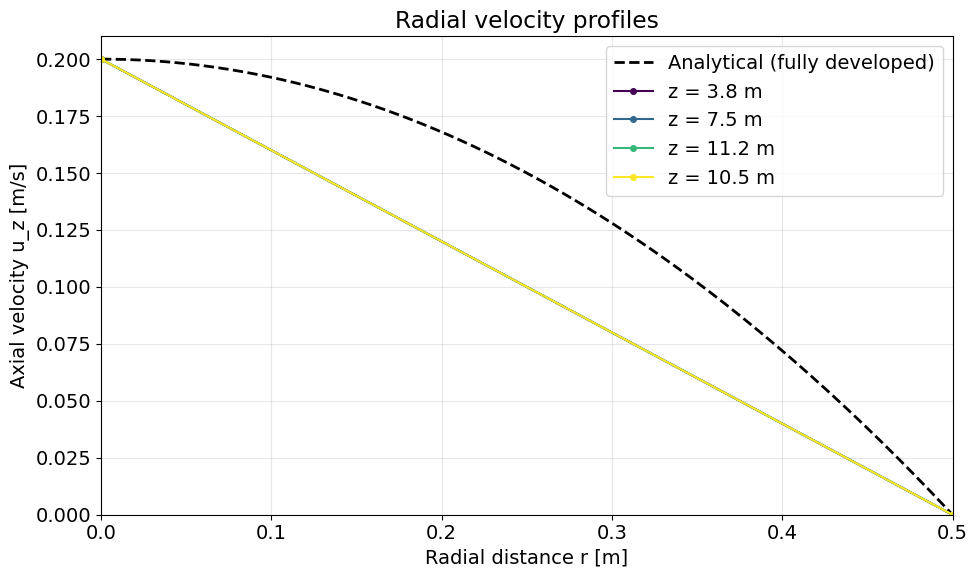

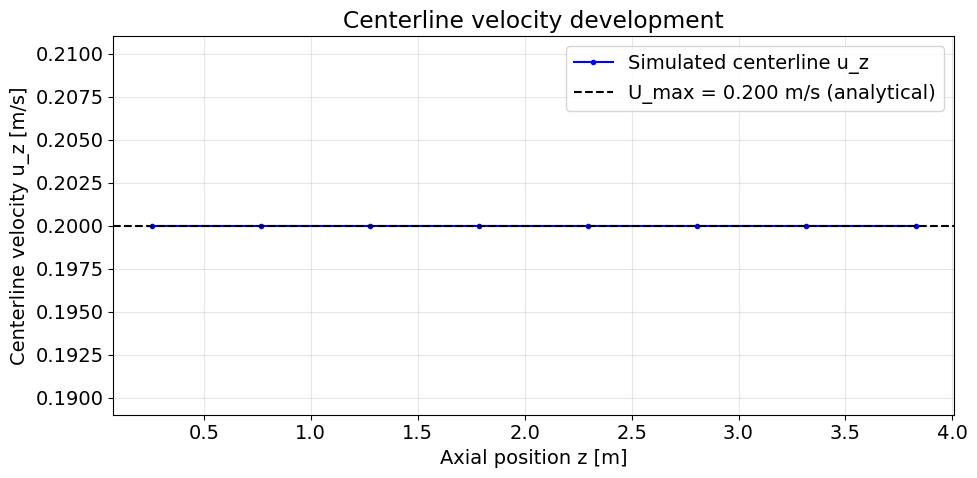

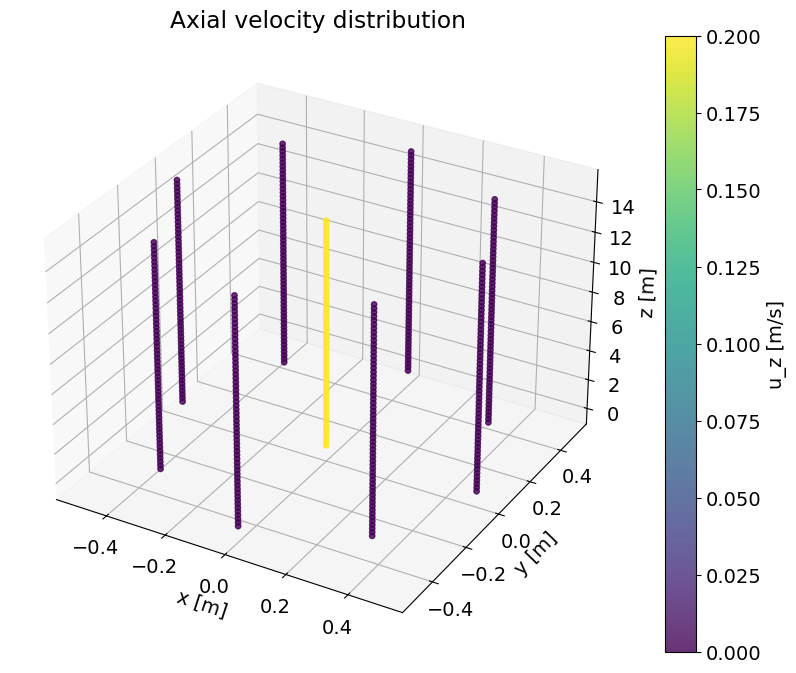

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'Axial velocity distribution'}, xlabel='x [m]', ylabel='y [m]', zlabel='z [m]'>)

In [7]:
print("Generating verification plots...")

# Disable LaTeX rendering (temporary fix for matplotlib issues)
plt.rcParams['text.usetex'] = False

# Radial profiles
z_positions = [-L/2 + 0.5, L/4, L/2, 3*L/4, L/2 + 3]
profiles = extract_radial_profiles(HC, z_positions, dr_tol=0.08)
plot_radial_profiles(profiles, U_max=U_max, r_max=r)

# Centerline
plot_centerline_velocity(HC, L=L, U_max=U_max)

# 3D velocity (safe version)
plot_3d_velocity(HC)

In [8]:
from src._mass import set_mass_3d

if 0:
    HC = cube_to_tube(r=r, refinements=refinements, height=L)

    # Assign mass immediately after mesh creation
    set_mass_3d(HC, r, L, rho=rho)

    # Apply equilibrium IC (velocity + pressure)
    set_equilibrium_IC_3d(HC, U_max=U_max, R=r, G=G)

    # Rebuild duals
    #compute_vd(HC, cdist=cdist)

## Import boundary condition functions

In [9]:
# Boundary conditions for developing flow
from src._boundary_conditions import (
    add_inlet_layer,
    remove_outlet_vertices,
    enforce_no_slip_walls,
    compute_inlet_flow_rate
)

In [10]:
if 0:
    # Main simulation loop skeleton for developing flow
    #n_steps = 500
    n_steps = 2
    dt = 0.01   # will be adjusted by CFL in real run

    inlet_z = -L/2 + 0.1
    z_max = L/2

    mass_history = []
    flow_rate_history = []

    for step in range(n_steps):
        # 1. Enforce wall BC
        enforce_no_slip_walls(HC)

        # 2. Add inlet layer periodically
        if step % add_inlet_every == 0:
            added = add_inlet_layer(HC, U_avg=U_avg, rho=rho, r=r, L=L,
                                    layer_thickness=inlet_layer_thickness,
                                    cdist=cdist)
            if added > 0:
                print(f"Step {step}: added {added} inlet vertices")

        # 3. Remove outlet vertices
        removed = remove_outlet_vertices(HC, z_max=z_max,
                                         outlet_buffer=outlet_buffer,
                                         cdist=cdist)
        if removed > 0:
            print(f"Step {step}: removed {removed} outlet vertices")

        # 4. Compute acceleration (your dudt) and advance positions/velocities
        # TODO: your integrator here (e.g., v.u += dudt(v) * dt; v.x_a += v.u * dt)

        # 5. Monitoring
        current_mass = sum(v.m for v in HC.V)
        Q_in = compute_inlet_flow_rate(HC, inlet_z)

        mass_history.append(current_mass)
    flow_rate_history.append(Q_in)

    if step % 50 == 0:
        print(f"Step {step}: mass = {current_mass:.6f}, Q_in ≈ {Q_in:.4f} m³/s")

    # Final checks
    print(f"\nFinal mass change: {abs(mass_history[-1] - mass_history[0]):.2e}")

3D tube: 819 vertices, 91 layers, height=15.0000 m
2D channel: 145 vertices, length=15.0000 m


In [32]:
from ddgclib._plotting import plot_polyscope, plot_dual

plot_polyscope(HC)

In [13]:
# src/_visualization.py
import polyscope as ps
import numpy as np
import copy

def init_polyscope(length_scale=1e-3):
    """Initialize Polyscope once."""
    ps.init()
    ps.set_up_dir('z_up')
    ps.set_ground_plane_mode('shadow_only')
    ps.set_length_scale(length_scale)
    ps.set_shadow_darkness(0.2)

def visualize_hc(
    HC,
    monitor_vertex=None,
    length_scale=1e-3,
    point_radii=1e-5,
    camera_pos=None,
    camera_target=None,
    screenshot_path=None,
    frame_idx=None,
    live=False
):
    """
    General visualization of an HC complex using the existing plot_dual.

    Parameters
    ----------
    HC : Complex
    monitor_vertex : Vertex or None
        Vertex passed to plot_dual (required by current implementation)
    live : bool
        If True → call ps.frame_tick() for live animation
        If False → only screenshot if path given
    screenshot_path : str or None
        If given, saves screenshot (appends frame_idx if provided)
    """
    if monitor_vertex is None:
        # Pick any interior vertex if none provided
        for v in HC.V:
            if not getattr(v, 'boundary', False) and not getattr(v, 'side_boundary', False):
                monitor_vertex = v
                break
        if monitor_vertex is None:
            monitor_vertex = next(iter(HC.V))  # fallback

    # Clear previous Polyscope structures
    ps.remove_all_structures()

    # Call the existing plot_dual (it registers everything)
    plot_dual(
        monitor_vertex,
        HC,
        length_scale=length_scale,
        point_radii=point_radii
    )


    # Camera setup
    if camera_pos is None:
        camera_pos = (0.0, -8.0 * length_scale, 3.0 * length_scale)
    if camera_target is None:
        camera_target = (0.0, 0.0, 0.0)
    ps.look_at(camera_pos, camera_target)

    # Screenshot
    if screenshot_path is not None:
        if frame_idx is not None:
            fname = f"{screenshot_path}_{frame_idx:04d}.png"
        else:
            fname = f"{screenshot_path}.png"
        ps.screenshot(fname)

    # Live update
    if live:
        ps.frame_tick()

    return monitor_vertex  # return in case it changed

In [14]:
# Visualization
#from src._visualization import init_polyscope, visualize_hc

In [15]:
# Initialize Polyscope once
init_polyscope(length_scale=1.0)
# Camara settings
# Set up direction so tube (z-axis) appears horizontal on screen
ps.set_up_dir('y_up')   # y is now vertical on screen, z is left-right (horizontal)

# Camera position for full tube visibility (side view, entire length visible)
camera_pos = (
    0.0,
    -max(D * 4.0, L * 0.8),   # pull back in y to see full length
    L / 2.0                   # center on tube length
)

camera_target = (0.0, 0.0, L / 2.0)   # look at middle of tube

ps.look_at(camera_pos, camera_target)

# Optional: wider field of view for long tubes
#ps.set_fov(50)   # degrees, default is ~45

# For L=15, r=0.5 (D=1), Re=100 case:
camera_pos = (0.0, -max(4.0, L*0.7), L/2.0)   # ≈ (0, -10.5, 7.5)
camera_target = (0.0, 0.0, L/2.0)
ps.look_at(camera_pos, camera_target)


dt = 0.02
n_frames = 80
screenshot_prefix = "./fig/poiseuille_advection/frame"

monitor_v = None

for i in range(n_frames):
    # Move every vertex at its current velocity (constant velocity test)
    moved = []
    for v in list(HC.V):  # list copy because merge may invalidate
        new_pos = v.x_a + dt * v.u
        new_v = HC.V.move(v, tuple(new_pos))
        moved.append(new_v)

    # Clean up topology
    HC.V.merge_all(cdist)
    compute_vd(HC, cdist=cdist)

    # Pick a monitor vertex (centerline near inlet)
    if monitor_v is None or monitor_v not in HC.V:
        for v in HC.V:
            if abs(v.x_a[2] + L/2) < 0.2 and np.linalg.norm(v.x_a[:2]) < 0.05:
                monitor_v = v
                break

    # Visualize
    visualize_hc(
        HC,
        monitor_vertex=monitor_v,
        length_scale=1.0,
        point_radii=5e-3,
        screenshot_path=screenshot_prefix,
        frame_idx=i,
        live=True   # set False if you prefer batch mode only
    )

    print(f"Frame {i:03d} | t = {i*dt:.3f} s")

print("Advection test complete. Check ./fig/poiseuille_advection/ for frames.")

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 590.48.01


IndexError: list index out of range

In [16]:
import time

# ... after mesh + IC + compute_vd ...

init_polyscope(length_scale=1.0)

dt = 0.02
n_frames = 80
screenshot_prefix = "./fig/poiseuille_advection/frame"

monitor_v = None

for i in range(n_frames):
    # 1. Advect vertices at constant velocity
    for v in list(HC.V):
        new_pos = v.x_a + dt * v.u
        HC.V.move(v, tuple(new_pos))

    # 2. Clean topology
    HC.V.merge_all(cdist)
    compute_vd(HC, cdist=cdist)

    # 3. Choose monitor vertex (centerline near inlet)
    if monitor_v is None or monitor_v not in HC.V:
        for v in HC.V:
            if abs(v.x_a[2] + L/2) < 0.2 and np.linalg.norm(v.x_a[:2]) < 0.05:
                monitor_v = v
                break
        if monitor_v is None:
            monitor_v = next(iter(HC.V))

    # 4. Visualize → screenshots only (no live frame_tick)
    visualize_hc(
        HC,
        monitor_vertex=monitor_v,
        length_scale=1.0,
        point_radii=5e-3,
        up_dir='y_up',
        camera_pos=(0.0, -max(D*6.0, L*0.8), L/2.0),
        camera_target=(0.0, 0.0, L/2.0),
        color_field=lambda v: v.u[2],
        cmap='viridis',
        screenshot_path=screenshot_prefix,
        frame_idx=i,
        live=False          # ← Critical: no frame_tick
    )

    print(f"Frame {i:03d} | t = {i*dt:.3f} s")

print(f"\nSaved {n_frames} frames to {screenshot_prefix}_*.png")

IndexError: list index out of range